# 편의점 지수 PRJ

Hyeshik Chang(장혜식)님의 [터미널엔 롯데리아, 동네에 맥도날드, 강남에 버거킹..?](http://highthroughput.org/wp/does-lotteria-locate-different/)과 <br>
PinkWink님의 [글](http://pinkwink.kr/1005)을 참고하여 우리나라의 편의점데이터를 분석&시각화해보았습니다.

In [1]:
import pandas as pd
import numpy as np
import re
from plotnine import *
import folium

In [2]:
# 2018 상권데이터 불러오기
shop1 = pd.read_csv('data/201806_01.csv')
shop2 = pd.read_csv('data/201806_02.csv')
shop3 = pd.read_csv('data/201806_03.csv')
shop4 = pd.read_csv('data/201806_04.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# 합치고 편의점을 뽑으려니 렉이 걸린다 ;-; 하나씩 해주자
store1 = shop1[shop1['상권업종소분류명'].str.contains('편의점')]
store2 = shop2[shop2['상권업종소분류명'].str.contains('편의점')]
store3 = shop3[shop3['상권업종소분류명'].str.contains('편의점')]
store4 = shop4[shop4['상권업종소분류명'].str.contains('편의점')]

In [4]:
# 편의점 데이터 합치기
frames = [store1, store2, store3, store4]
store_sum = pd.concat(frames)

In [5]:
store_sum.head(2)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
379,22143908,코리아세븐하단제휴점,NaN,D,소매,D03,종합소매점,D03A01,편의점,G47122,...,2.638010e+24,NaN,부산광역시 사하구 낙동대로 474,604020,49325.0,NaN,1,NaN,128.968208,35.107159
528,22565484,GS25해운리베라,NaN,D,소매,D03,종합소매점,D03A01,편의점,G47122,...,2.635010e+24,NaN,부산광역시 해운대구 구남로29번길 26,612010,48095.0,NaN,1,NaN,129.161980,35.162279


C:\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


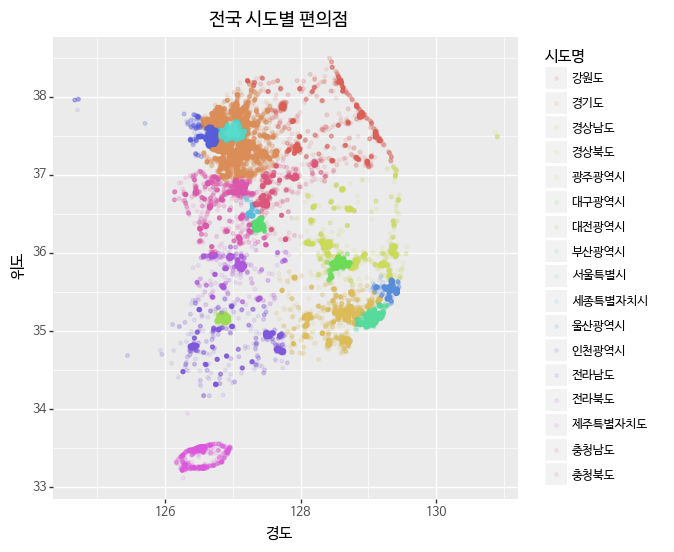

<ggplot: (56053035)>

In [6]:
# 전 지역 데이터가 있는지 찍어보자~ 다있는 것 같당
(ggplot(store_sum)
 + aes(x='경도', y='위도', color='시도명')
 + geom_point(size=1, alpha=0.1)
 + ggtitle('전국 시도별 편의점')
 + theme(text=element_text(family='NanumBarunGothic'),
        figure_size=(6, 6))
)

In [7]:
# 시도명과 시군구명을 합쳐서 지역칼럼만들기
store_sum['지역'] = store_sum['시도명'] + ' ' + store_sum['시군구명']

In [8]:
# 지역칼럼 넣어줌
store = store_sum[['상호명', '지역', '시군구코드', '경도', '위도']]
store.head(2)

,상호명,지역,시군구코드,경도,위도
379,코리아세븐하단제휴점,부산광역시 사하구,26380,128.968208,35.107159
528,GS25해운리베라,부산광역시 해운대구,26350,129.161980,35.162279


# 1. 지역명 전처리

In [9]:
store.tail()

,상호명,지역,시군구코드,경도,위도
679984,CU,전라북도 전주시 덕진구,45113,127.133156,35.878444
680091,세븐일레븐,전라남도 여수시,46130,127.658265,34.757472
680248,세븐일레븐,전라남도 여수시,46130,127.741365,34.737393
680294,미니스톱,경상남도 김해시,48250,128.915462,35.240697
680446,GS25,경상남도 창원시 성산구,48123,128.600213,35.168889


### 지역을 보니...! 시 옆에 구도 따라온다.  
도는 d1으로, 시는 d2로 칼럼을 저장해준 뒤 지역2로 만들어주기.

In [10]:
store['d1'] = store['지역'].apply(lambda do_si : do_si.split(' ')[0])
store['d2'] = store['지역'].apply(lambda do_si : do_si.split(' ')[1])
store['지역2'] = store['d1'] + ' ' + store['d2']
store.tail()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

,상호명,지역,시군구코드,경도,위도,d1,d2,지역2
679984,CU,전라북도 전주시 덕진구,45113,127.133156,35.878444,전라북도,전주시,전라북도 전주시
680091,세븐일레븐,전라남도 여수시,46130,127.658265,34.757472,전라남도,여수시,전라남도 여수시
680248,세븐일레븐,전라남도 여수시,46130,127.741365,34.737393,전라남도,여수시,전라남도 여수시
680294,미니스톱,경상남도 김해시,48250,128.915462,35.240697,경상남도,김해시,경상남도 김해시
680446,GS25,경상남도 창원시 성산구,48123,128.600213,35.168889,경상남도,창원시,경상남도 창원시


In [11]:
store = store[['상호명', '지역2', 'd1', 'd2', '시군구코드', '경도', '위도']]
store.tail()

,상호명,지역2,d1,d2,시군구코드,경도,위도
679984,CU,전라북도 전주시,전라북도,전주시,45113,127.133156,35.878444
680091,세븐일레븐,전라남도 여수시,전라남도,여수시,46130,127.658265,34.757472
680248,세븐일레븐,전라남도 여수시,전라남도,여수시,46130,127.741365,34.737393
680294,미니스톱,경상남도 김해시,경상남도,김해시,48250,128.915462,35.240697
680446,GS25,경상남도 창원시,경상남도,창원시,48123,128.600213,35.168889


# 2. 편의점 종류 분류

In [12]:
gs = store[(store['상호명'].str.contains(r'GS25|gs25|지에스이십오|^GS$|gs이십오|지에스(25)?|GS[가-힣]|[가-힣]GS'))]
cu = store[(store['상호명'].str.contains(r'^씨유|CU|\bcu'))]
seven = store[(store['상호명'].str.contains(r'세븐|seven|7|Seven|SEVEN'))]
mini = store[(store['상호명'].str.contains(r'미니|mini|MINI'))]
emart =store[(store['상호명'].str.contains(r'^[eE]-?mart|^[eE]-?MART|^이마트|클루이마트|이마트24|위드미|withme'))]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [13]:
gs['편의점'] = 'GS25'
cu['편의점'] = 'CU'
seven['편의점'] = '7ELEVEN'
mini['편의점'] = 'MINISTOP'
emart['편의점'] = 'EMART'

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [14]:
gs = gs[['상호명', '편의점', '지역2', 'd1', 'd2', '시군구코드', '경도', '위도']]
cu = cu[['상호명', '편의점', '지역2', 'd1', 'd2', '시군구코드', '경도', '위도']]
seven = seven[['상호명', '편의점', '지역2', 'd1', 'd2', '시군구코드', '경도', '위도']]
mini = mini[['상호명', '편의점', '지역2', 'd1', 'd2', '시군구코드', '경도', '위도']]
emart = emart[['상호명', '편의점', '지역2', 'd1', 'd2', '시군구코드', '경도', '위도']]

In [15]:
frames = [gs, cu, seven, mini, emart]
gmap = pd.concat(frames)
gmap.tail()

,상호명,편의점,지역2,d1,d2,시군구코드,경도,위도
667768,이마트,EMART,경상북도 상주시,경상북도,상주시,47250,128.151035,36.410005
667776,이마트,EMART,경상남도 김해시,경상남도,김해시,48250,128.904998,35.253232
671427,이마트24남악원룸점,EMART,전라남도 무안군,전라남도,무안군,46840,126.473411,34.810732
672931,이마트24보령우연플로라점,EMART,충청남도 보령시,충청남도,보령시,44180,126.512590,36.313145
679428,이마트,EMART,충청남도 당진시,충청남도,당진시,44270,126.637774,36.885057


In [16]:
# gs.to_csv('data/gs.csv', index=False)
# cu.to_csv('data/cu.csv', index=False)
# seven.to_csv('data/seven.csv', index=False)
# mini.to_csv('data/mini.csv', index=False)
# emart.to_csv('data/emart.csv', index=False)

C:\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


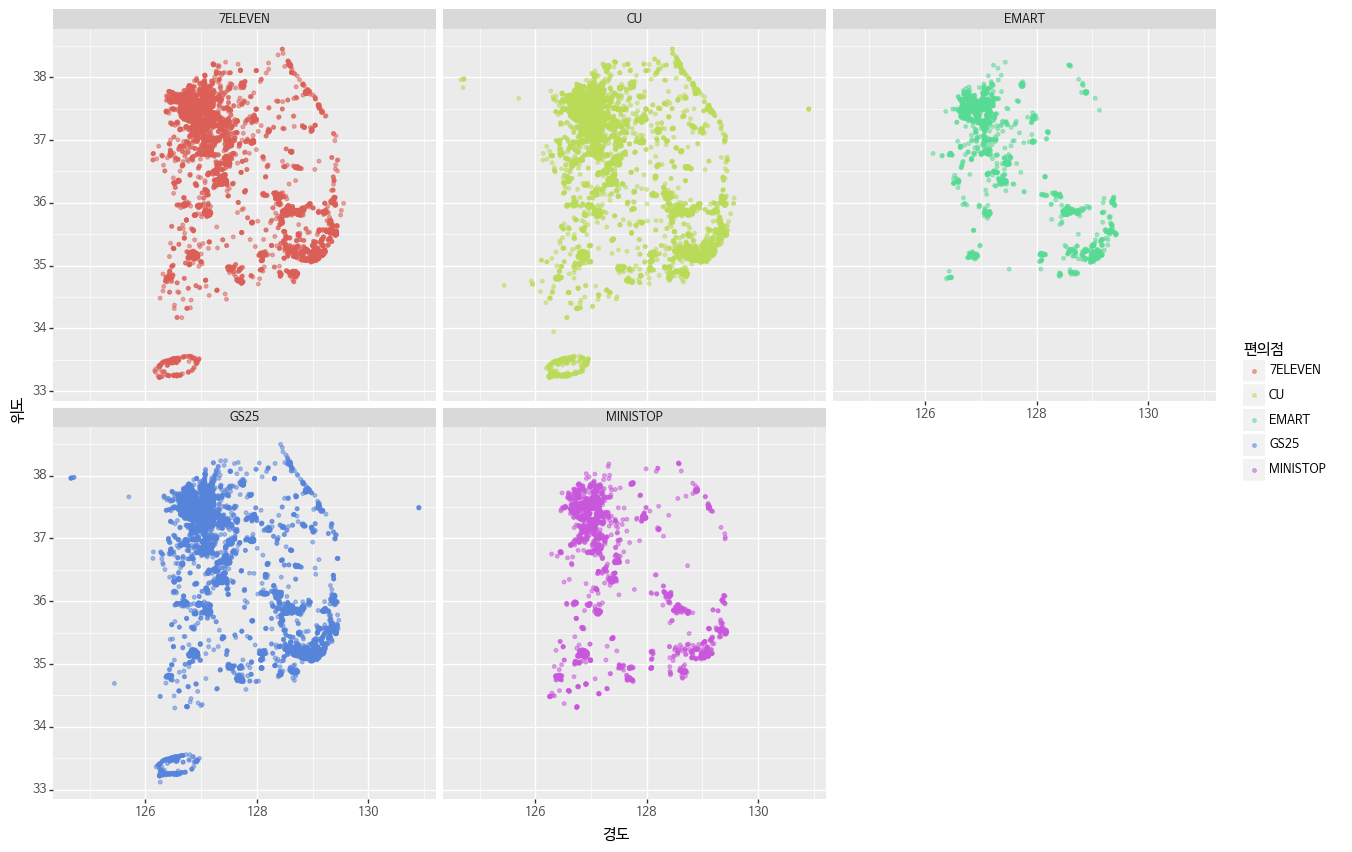

<ggplot: (-9223372036738235206)>

In [17]:
(ggplot(gmap)
 + aes(x='경도', y='위도', color='편의점')
 + geom_point(size=1, alpha=0.5)
 + facet_wrap('편의점')
 + theme(text=element_text(family='NanumBarunGothic'),
        figure_size=(15, 10))
)

# 3. 지역별로 df 만들기
지역2 기준으로 편의점 종류별 합 df를 만듬

In [18]:
gs_sum = gs['지역2'].value_counts()
cu_sum = cu['지역2'].value_counts()
seven_sum = seven['지역2'].value_counts()
mini_sum = mini['지역2'].value_counts()
emart_sum = emart['지역2'].value_counts()

In [19]:
# 빈 값은 0으로 대체해주기
convenience_store_df = pd.DataFrame({'GS25': gs_sum, 'CU': cu_sum, '7ELEVEN': seven_sum, 'MINISTOP': mini_sum, 'EMART': emart_sum}).fillna(0)
convenience_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 강원도 강릉시 to 충청북도 충주시
Data columns (total 5 columns):
GS25        229 non-null float64
CU          229 non-null float64
7ELEVEN     229 non-null float64
MINISTOP    229 non-null float64
EMART       229 non-null float64
dtypes: float64(5)
memory usage: 10.7+ KB


In [20]:
# 지역별 편의점 수의 합을 total 칼럼에 저장
convenience_store_df['total'] = convenience_store_df.sum(axis=1)
convenience_store_df.head(10)

,GS25,CU,7ELEVEN,MINISTOP,EMART,total
강원도 강릉시,78.0,74.0,70.0,23.0,16.0,261.0
강원도 고성군,8.0,15.0,8.0,0.0,0.0,31.0
강원도 동해시,32.0,44.0,15.0,16.0,1.0,108.0
강원도 삼척시,21.0,36.0,13.0,4.0,0.0,74.0
강원도 속초시,33.0,40.0,26.0,4.0,5.0,108.0
강원도 양구군,3.0,10.0,4.0,1.0,0.0,18.0
강원도 양양군,14.0,21.0,11.0,1.0,1.0,48.0
강원도 영월군,17.0,16.0,3.0,0.0,0.0,36.0
강원도 원주시,111.0,104.0,88.0,50.0,24.0,377.0
강원도 인제군,12.0,17.0,6.0,3.0,0.0,38.0


In [21]:
convenience_store_df = convenience_store_df.astype(int)
convenience_store_df.head()

,GS25,CU,7ELEVEN,MINISTOP,EMART,total
강원도 강릉시,78,74,70,23,16,261
강원도 고성군,8,15,8,0,0,31
강원도 동해시,32,44,15,16,1,108
강원도 삼척시,21,36,13,4,0,74
강원도 속초시,33,40,26,4,5,108


## (상관계수 확인해보기)

In [22]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot')
rcParams['font.size'] = 12

전국 편의점은 GS25 > CU > 7ELEVEN > MINISTOP > EMART 순으로 많다.


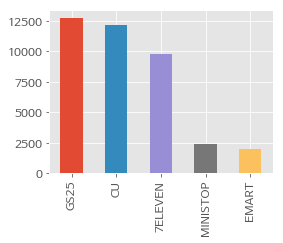

In [23]:
plt.figure(figsize=(4, 3))
convenience_store_df.sum(axis=0).iloc[:5].plot(kind='bar')
print ("전국 편의점은 GS25 > CU > 7ELEVEN > MINISTOP > EMART 순으로 많다.")

In [24]:
import scipy.stats

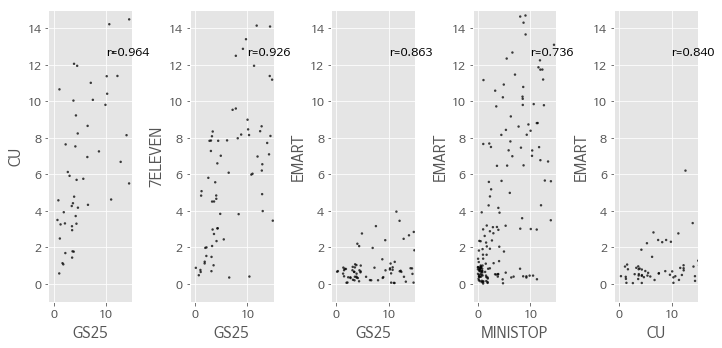

In [25]:
fig = plt.figure(figsize=(10,5))

def plot_nstores(b1, b2, label1, label2):
    plt.scatter(convenience_store_df[b1] + np.random.random(len(convenience_store_df)),
                convenience_store_df[b2] + np.random.random(len(convenience_store_df)),
                edgecolor='none', alpha=0.75, s=6, c='black')
    plt.xlim(-1, 15)
    plt.ylim(-1, 15)
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    r = scipy.stats.pearsonr(convenience_store_df[b1], convenience_store_df[b2])
    plt.annotate('r={:.3f}'.format(r[0]), (10, 12.5))

ax = fig.add_subplot(1, 5, 1)
plot_nstores('GS25', 'CU', 'GS25', 'CU')

ax = fig.add_subplot(1, 5, 2)
plot_nstores('GS25', '7ELEVEN', 'GS25', '7ELEVEN')

ax = fig.add_subplot(1, 5, 3)
plot_nstores('GS25', 'EMART', 'GS25', 'EMART')

ax = fig.add_subplot(1, 5, 4)
plot_nstores('MINISTOP', 'EMART', 'MINISTOP', 'EMART')

ax = fig.add_subplot(1, 5, 5)
plot_nstores('CU', 'EMART', 'CU', 'EMART')

plt.tight_layout()

Text(0,0.5,'Cumulative fraction')

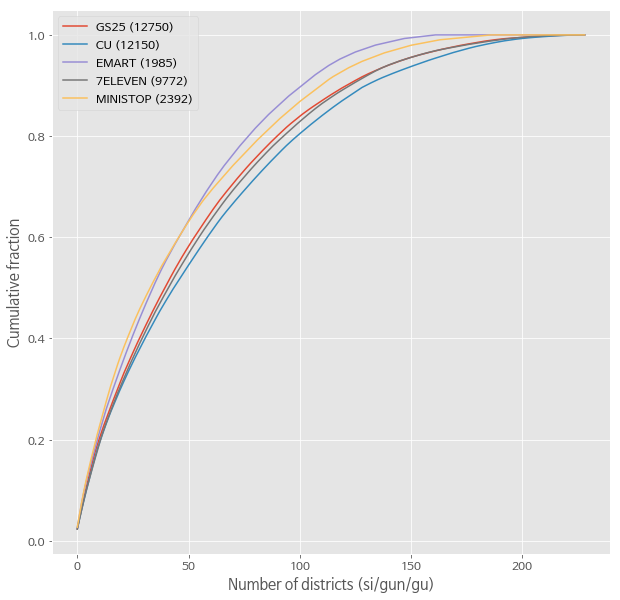

In [26]:
plt.figure(figsize=(10, 10))
for col, label in [('GS25', 'GS25'), ('CU', 'CU'), ('EMART', "EMART"), ('7ELEVEN', "7ELEVEN"), ('MINISTOP',"MINISTOP") ]:
    cumulv = np.cumsum(sorted(convenience_store_df[col], reverse=True)) / convenience_store_df[col].sum()
    plt.plot(cumulv, label='{} ({})'.format(label, int(convenience_store_df[col].sum())))
plt.legend(loc='best')
plt.xlabel('Number of districts (si/gun/gu)')
plt.ylabel('Cumulative fraction')

EMART > MINISTOP > GS25 > 7ELEVEN > CU 순으로 지역집중도가 높은 것을 확인,
CU가 가장 전국에 잘 흩어져 있다는 것을 확인했다.

# 4. 블록 맵 만들기

### 지역2로 인덱스로 들어가 있는 상태! d1과 d2를 다시 추가해주자. 

In [27]:
convenience_store_df.head()

,GS25,CU,7ELEVEN,MINISTOP,EMART,total
강원도 강릉시,78,74,70,23,16,261
강원도 고성군,8,15,8,0,0,31
강원도 동해시,32,44,15,16,1,108
강원도 삼척시,21,36,13,4,0,74
강원도 속초시,33,40,26,4,5,108


In [28]:
convenience_store_df['지역'] = convenience_store_df.index
convenience_store_df.head()

,GS25,CU,7ELEVEN,MINISTOP,EMART,total,지역
강원도 강릉시,78,74,70,23,16,261,강원도 강릉시
강원도 고성군,8,15,8,0,0,31,강원도 고성군
강원도 동해시,32,44,15,16,1,108,강원도 동해시
강원도 삼척시,21,36,13,4,0,74,강원도 삼척시
강원도 속초시,33,40,26,4,5,108,강원도 속초시


In [29]:
convenience_store_df['d1'] = convenience_store_df['지역'].apply(lambda do_si : do_si.split(' ')[0])
convenience_store_df['d2'] = convenience_store_df['지역'].apply(lambda do_si : do_si.split(' ')[1])
convenience_store_df.tail()

,GS25,CU,7ELEVEN,MINISTOP,EMART,total,지역,d1,d2
충청북도 제천시,37,43,26,6,7,119,충청북도 제천시,충청북도,제천시
충청북도 증평군,16,12,9,1,0,38,충청북도 증평군,충청북도,증평군
충청북도 진천군,20,21,33,3,1,78,충청북도 진천군,충청북도,진천군
충청북도 청주시,235,220,156,39,49,699,충청북도 청주시,충청북도,청주시
충청북도 충주시,55,79,51,1,15,201,충청북도 충주시,충청북도,충주시


In [30]:
# 보기 좋게 칼럼 순서 변경
convenience_store_df = convenience_store_df[['d1', 'd2', 'GS25', 'CU', '7ELEVEN', 'MINISTOP', 'EMART', 'total']]
convenience_store_df.tail()

,d1,d2,GS25,CU,7ELEVEN,MINISTOP,EMART,total
충청북도 제천시,충청북도,제천시,37,43,26,6,7,119
충청북도 증평군,충청북도,증평군,16,12,9,1,0,38
충청북도 진천군,충청북도,진천군,20,21,33,3,1,78
충청북도 청주시,충청북도,청주시,235,220,156,39,49,699
충청북도 충주시,충청북도,충주시,55,79,51,1,15,201


In [31]:
# 편의점지수('CU', '7ELEVEN', 'MINISTOP', 'EMART'의 합/'GS25'의 수)를 구해 DF에 저장
convenience_store_df['C7ME'] = convenience_store_df['CU'] + convenience_store_df['7ELEVEN'] + convenience_store_df['MINISTOP'] + convenience_store_df['EMART']
convenience_store_df['편의점지수'] = convenience_store_df['C7ME'] / convenience_store_df['GS25']

# 편의점지수를 기준으로 정렬
convenience_df_sort = convenience_store_df.sort_values(by=['편의점지수'], ascending=False)
convenience_df_sort.head()

,d1,d2,GS25,CU,7ELEVEN,MINISTOP,EMART,total,C7ME,편의점지수
전라북도 진안군,전라북도,진안군,0,3,0,0,0,3,3,inf
전라북도 장수군,전라북도,장수군,0,4,0,0,0,4,4,inf
전라남도 고흥군,전라남도,고흥군,3,19,7,8,0,37,34,11.333333
전라남도 신안군,전라남도,신안군,1,10,1,0,0,12,11,11.000000
전라남도 보성군,전라남도,보성군,1,1,5,3,0,10,9,9.000000


지역명을 짧은 이름으로 매치시키기

In [32]:
# 고성군은 강원도, 경상남도에 있으므로 ()안에 표시해주기
# 세종특별시는 세종으로 바꿔줌
# 인천옹진, 울산울주, 대구달성, 부산기장은 군이라서 따로 설정해줘야 함! 억지로 넣어버려 ㅇㅅㅇ!
def short_distr(name):
    wide, narrow = name.split()
    if narrow.endswith('구'):
        return wide[:2] + (narrow[:-1] if len(narrow) > 2 else narrow)
    elif narrow == '고성군':
        return '고성({})'.format({'강원도': '강원', '경상남도': '경남'}[wide])
    elif narrow == '세종특별자치시': 
        return '세종'
    elif narrow == '옹진군': 
        return '인천옹진'
    elif narrow == '울주군': 
        return '울산울주'
    elif narrow == '달성군': 
        return '대구달성'
    elif narrow == '기장군': 
        return '부산기장'
    else:
        return narrow[:-1]

convenience_df_sort['shortname'] = list(map(short_distr, convenience_df_sort.index))
convenience_df_sort['shortname'].unique()

array(['진안', '장수', '고흥', '신안', '보성', '횡성', '진도', '고창', '화순', '함평', '무주',
       '함양', '철원', '영동', '양구', '안성', '목포', '광주광산', '고령', '광주남구', '나주',
       '해남', '괴산', '순창', '의령', '영주', '장흥', '강화', '부안', '정읍', '양평', '옥천',
       '담양', '영광', '태안', '거창', '부산수영', '대구중구', '강진', '세종', '무안', '부산부산진',
       '구미', '대구남구', '칠곡', '평창', '광주서구', '봉화', '영양', '서산', '대전대덕', '진천',
       '인천동구', '울산동구', '과천', '고성(강원)', '부산동래', '부산강서', '밀양', '보령', '영천',
       '대구동구', '영덕', '부산연제', '대구수성', '충주', '거제', '가평', '대구달서', '제주', '홍천',
       '평택', '삼척', '홍성', '울산남구', '부산금정', '연천', '안산', '김포', '대구북구', '춘천',
       '부산서구', '양양', '광주북구', '경주', '통영', '원주', '광양', '인천중구', '동해', '부산남구',
       '강릉', '의성', '청양', '음성', '광주동구', '완도', '포천', '부여', '영암', '인천연수',
       '사천', '속초', '서귀포', '부산기장', '함안', '공주', '부산사상', '제천', '부산동구', '인제',
       '보은', '양주', '의정부', '전주', '서울종로', '태백', '익산', '인천계양', '서울강북',
       '대구달성', '논산', '남해', '서울용산', '남양주', '고성(경남)', '서울서초', '고양', '인천남동',
       '창녕', '당진', '울산중구', '포항', '서울도봉', '인천부평', '군포'

In [33]:
blockpositions = pd.read_csv('data/blockpositions.csv', names=range(15))
blockpositions.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,NaN,철원,화천,양구,고성(강원),NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,서울도봉,서울노원,연천,포천,속초,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,파주,고양,서울강북,서울성북,동두천,양주,인제,양양,NaN,NaN,NaN,NaN
3,NaN,강화,김포,광명,서울은평,서울서대문,서울종로,의정부,남양주,가평,춘천,NaN,NaN,NaN,NaN
4,NaN,인천서구,부천,안양,서울강서,서울마포,서울중구,서울동대문,서울중랑,구리,홍천,강릉,NaN,NaN,NaN


In [34]:
flatrows = []
for y, colcities in blockpositions.iterrows():
    for x, city in colcities.iteritems():
        if isinstance(city, str):
            flatrows.append((x, y, city))

blockpositions_tbl = pd.DataFrame(flatrows, columns=('x', 'y', 'city')).set_index('city').sort_index()
convenience_df_sort_b = pd.merge(convenience_df_sort, blockpositions_tbl, how='left', left_on='shortname', right_index=True)
convenience_df_sort_b.head()

,d1,d2,GS25,CU,7ELEVEN,MINISTOP,EMART,total,C7ME,편의점지수,shortname,x,y
전라북도 진안군,전라북도,진안군,0,3,0,0,0,3,3,inf,진안,4,16
전라북도 장수군,전라북도,장수군,0,4,0,0,0,4,4,inf,장수,5,16
전라남도 고흥군,전라남도,고흥군,3,19,7,8,0,37,34,11.333333,고흥,3,22
전라남도 신안군,전라남도,신안군,1,10,1,0,0,12,11,11.000000,신안,0,19
전라남도 보성군,전라남도,보성군,1,1,5,3,0,10,9,9.000000,보성,3,21


In [35]:
convenience_df_sort_b[convenience_df_sort_b['x'].apply(np.isnan)]

,d1,d2,GS25,CU,7ELEVEN,MINISTOP,EMART,total,C7ME,편의점지수,shortname,x,y


ㅠㅠ 다들어 갔다ㅜㅜㅠㅡ 이제 그림그리기!

In [36]:
from matplotlib import rcParams
from matplotlib import cm, colors, _cm
rcParams['font.family'] = 'NanumBarunGothic'

In [37]:
# 편의점지수가 (inf)무한대인 곳이 있다..0으로 넣어주자....
from numpy import inf
convenience_df_sort_b['편의점지수'] = convenience_df_sort['편의점지수'].replace(np.inf, 0)

In [38]:
convenience_df_sort_b.head(2)

,d1,d2,GS25,CU,7ELEVEN,MINISTOP,EMART,total,C7ME,편의점지수,shortname,x,y
전라북도 진안군,전라북도,진안군,0,3,0,0,0,3,3,0.0,진안,4,16
전라북도 장수군,전라북도,장수군,0,4,0,0,0,4,4,0.0,장수,5,16


In [39]:
BORDER_LINES = [
    [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천
    [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울
    [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9),
     (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도
    [(9, 12), (9, 10), (8, 10)], # 강원도
    [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5),
     (13, 4), (14, 4), (14, 2)], # 충청남도
    [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7),
     (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도
    [(14, 4), (15, 4), (15, 6)], # 대전시
    [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도
    [(14, 8), (16, 8), (16, 10), (15, 10),
     (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시
    [(15, 11), (16, 11), (16, 13)], # 울산시
    [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도
    [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시
    [(18, 5), (20, 5), (20, 6)], # 전라남도
    [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시
]

In [40]:
# 블록맵을 만들기 위해 draw_blockmap함수 생성
# draw_blockmap('column', df, 'd1', 'd2', 'color', np.arange(start, stop, step), 'title')
def draw_blockmap(targetData, blockedMap, d1, d2, cmapname, dataticks, title):
    gamma = 0.75

    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData])) * 0.5 + min(blockedMap[targetData])

    datalabel = targetData

    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])

    mapdata = blockedMap.pivot(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 12))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, edgecolor='#aaaaaa', linewidth=0.6)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'

        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. (중구, 서구)
        if row[d1].endswith('시') and not row[d1].startswith('세종'):
            dispname = '{}\n{}'.format(row[d1][:2], row[d2][:-1])
            if len(row[d2]) <= 2:
                dispname += row[d2][-1]
        elif row[d1].startswith('세종'):
            dispname = '세종'
        else:
            dispname = row[d2][:-1]

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 9.5, 1.2
        else:
            fontsize, linespacing = 12, 1.2

        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=12.6, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)
        
    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=1.2)

    plt.gca().invert_yaxis()
    #plt.gca().set_aspect(1)

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)
    cb.set_ticks(dataticks)
    
    # title 생성
    plt.tight_layout()
    plt.title(title, y=1.02, loc='left', fontproperties='NanumBarunGothic', fontsize=18, fontweight='bold')

    plt.show()

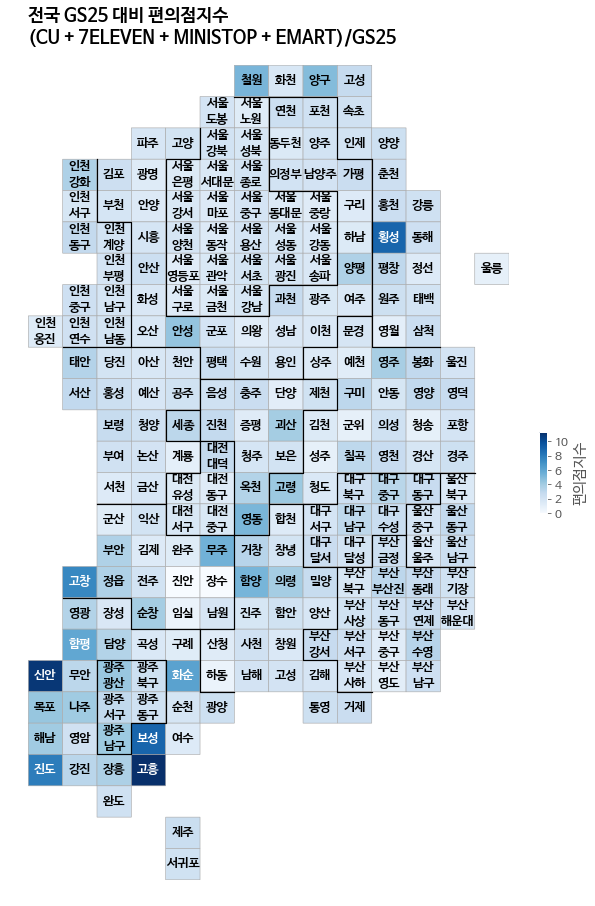

In [41]:
draw_blockmap('편의점지수', convenience_df_sort_b, 'd1', 'd2', 'Blues', np.arange(0, 10.1, 2), 
              '전국 GS25 대비 편의점지수\n(CU + 7ELEVEN + MINISTOP + EMART)/GS25')

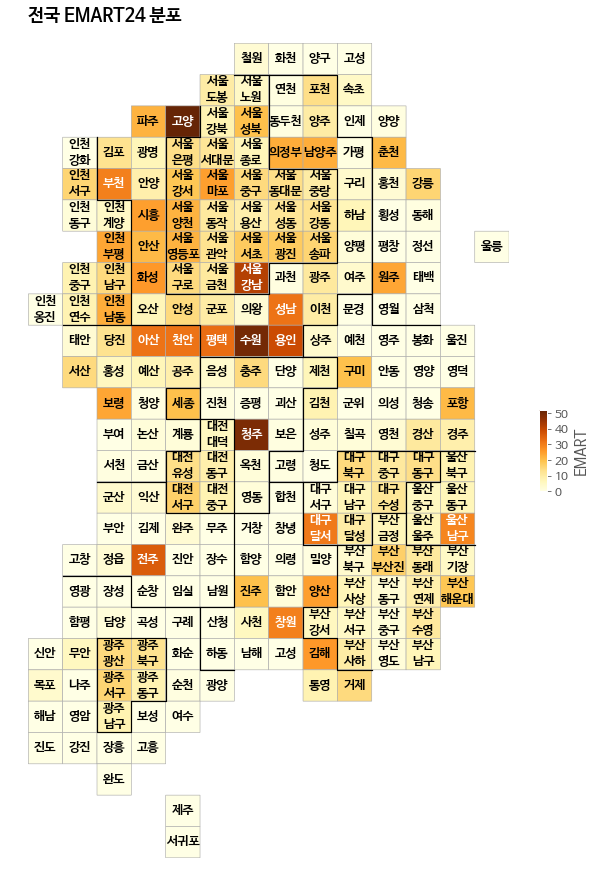

In [42]:
draw_blockmap('EMART', convenience_df_sort_b, 'd1', 'd2', 'YlOrBr', np.arange(0, 60.1, 10),
             '전국 EMART24 분포')

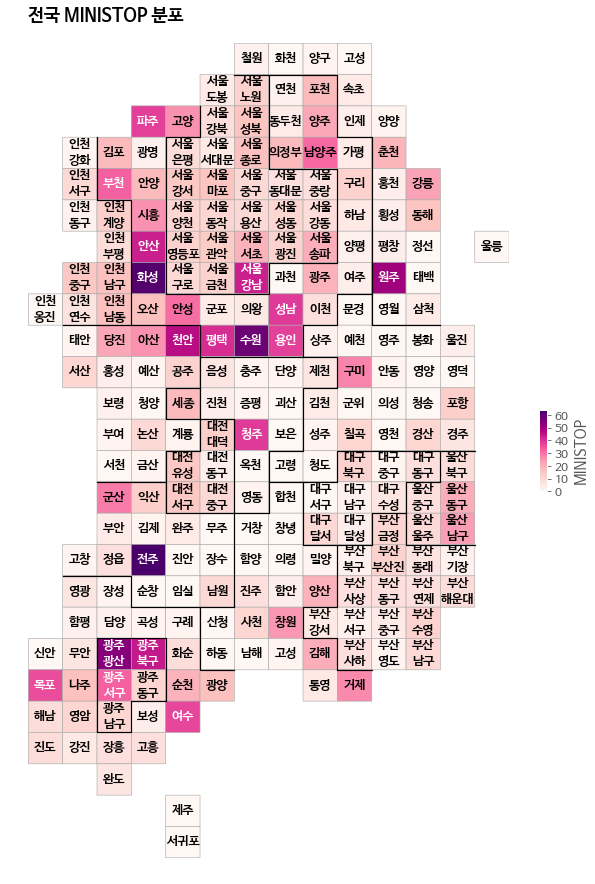

In [43]:
draw_blockmap('MINISTOP', convenience_df_sort_b, 'd1', 'd2', 'RdPu', np.arange(0, 60.1,10),
             '전국 MINISTOP 분포')

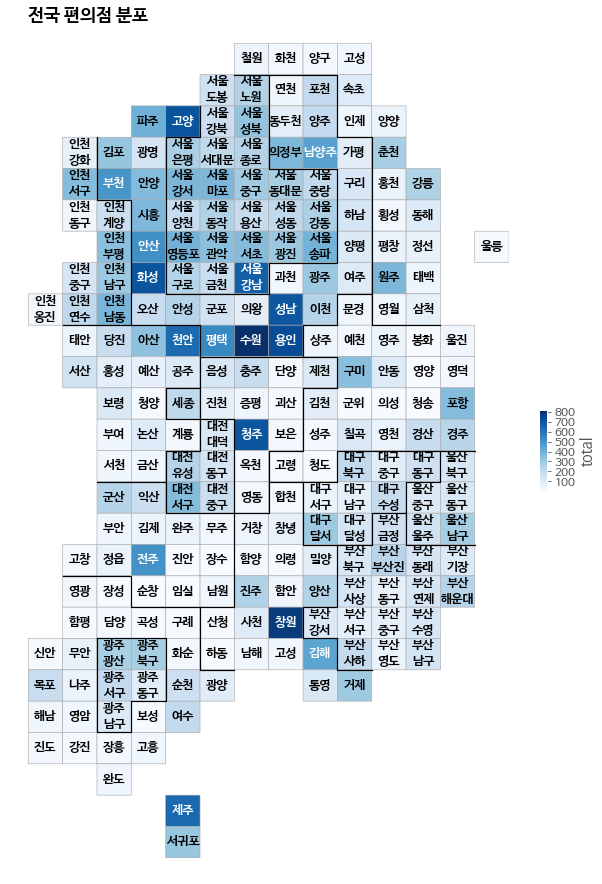

In [44]:
draw_blockmap('total', convenience_df_sort_b, 'd1', 'd2', 'Blues', np.arange(100, 800.1, 100),
             '전국 편의점 분포')

### 지역데이터도 df에 넣어주자

In [45]:
population = pd.read_csv('data/population.csv')
population.head()

,소재지(시군구)별(1),소재지(시군구)별(2),2017,2017 .1,2017
0,소재지(시군구)별(1),소재지(시군구)별(2),전체인구(A) (명),지역면적,인구밀도
1,소재지(시군구)별(1),소재지(시군구)별(2),소계,소계,소계
2,전국,소계,51778544,100363714871,0.000515909
3,서울특별시,소계,9857426,605242800,0.01628673
4,서울특별시,종로구,154770,23912788,0.006472269


In [46]:
# 칼럼지정
column_name = ['d1', 'd2', '인구수', '지역면적', '인구밀도']
population.columns = column_name
population.head()

,d1,d2,인구수,지역면적,인구밀도
0,소재지(시군구)별(1),소재지(시군구)별(2),전체인구(A) (명),지역면적,인구밀도
1,소재지(시군구)별(1),소재지(시군구)별(2),소계,소계,소계
2,전국,소계,51778544,100363714871,0.000515909
3,서울특별시,소계,9857426,605242800,0.01628673
4,서울특별시,종로구,154770,23912788,0.006472269


In [47]:
population = population.drop(population.index[[0, 1, 2, 3]])
population.head()

,d1,d2,인구수,지역면적,인구밀도
4,서울특별시,종로구,154770,23912788,0.006472269
5,서울특별시,중구,125709,9959791,0.01262165
6,서울특별시,용산구,229161,21866466,0.01048002
7,서울특별시,성동구,304808,16856985,0.018082
8,서울특별시,광진구,357703,17063241,0.020963368


In [48]:
# population의 인덱스를 d1+d2로 지정
population.index = population.apply(lambda r: r['d1'] + ' ' + r['d2'], axis=1)

In [49]:
# convenience_df_sort_b와 합쳐주기
df = pd.merge(population, convenience_df_sort_b, how='outer', left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 강원도 강릉시 to 충청북도 충주시
Data columns (total 18 columns):
d1_x         245 non-null object
d2_x         245 non-null object
인구수          245 non-null object
지역면적         245 non-null object
인구밀도         245 non-null object
d1_y         229 non-null object
d2_y         229 non-null object
GS25         229 non-null float64
CU           229 non-null float64
7ELEVEN      229 non-null float64
MINISTOP     229 non-null float64
EMART        229 non-null float64
total        229 non-null float64
C7ME         229 non-null float64
편의점지수        229 non-null float64
shortname    229 non-null object
x            229 non-null float64
y            229 non-null float64
dtypes: float64(10), object(8)
memory usage: 36.4+ KB


In [50]:
# 소계였던 열은 NaN으로 되어있을 것, NaN전체행날리기
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 강원도 강릉시 to 충청북도 충주시
Data columns (total 18 columns):
d1_x         229 non-null object
d2_x         229 non-null object
인구수          229 non-null object
지역면적         229 non-null object
인구밀도         229 non-null object
d1_y         229 non-null object
d2_y         229 non-null object
GS25         229 non-null float64
CU           229 non-null float64
7ELEVEN      229 non-null float64
MINISTOP     229 non-null float64
EMART        229 non-null float64
total        229 non-null float64
C7ME         229 non-null float64
편의점지수        229 non-null float64
shortname    229 non-null object
x            229 non-null float64
y            229 non-null float64
dtypes: float64(10), object(8)
memory usage: 34.0+ KB


In [51]:
df[['인구수', '지역면적', '인구밀도']] = df[['인구수', '지역면적', '인구밀도']].astype(float)

In [52]:
df.head()

,d1_x,d2_x,인구수,지역면적,인구밀도,d1_y,d2_y,GS25,CU,7ELEVEN,MINISTOP,EMART,total,C7ME,편의점지수,shortname,x,y
강원도 강릉시,강원도,강릉시,213952.0,1.040709e+09,0.000206,강원도,강릉시,78.0,74.0,70.0,23.0,16.0,261.0,183.0,2.346154,강릉,11.0,4.0
강원도 고성군,강원도,고성군,30029.0,6.608589e+08,0.000045,강원도,고성군,8.0,15.0,8.0,0.0,0.0,31.0,23.0,2.875000,고성(강원),9.0,0.0
강원도 동해시,강원도,동해시,92851.0,1.802061e+08,0.000515,강원도,동해시,32.0,44.0,15.0,16.0,1.0,108.0,76.0,2.375000,동해,11.0,5.0
강원도 삼척시,강원도,삼척시,68514.0,1.186956e+09,0.000058,강원도,삼척시,21.0,36.0,13.0,4.0,0.0,74.0,53.0,2.523810,삼척,11.0,8.0
강원도 속초시,강원도,속초시,82273.0,1.057355e+08,0.000778,강원도,속초시,33.0,40.0,26.0,4.0,5.0,108.0,75.0,2.272727,속초,9.0,1.0


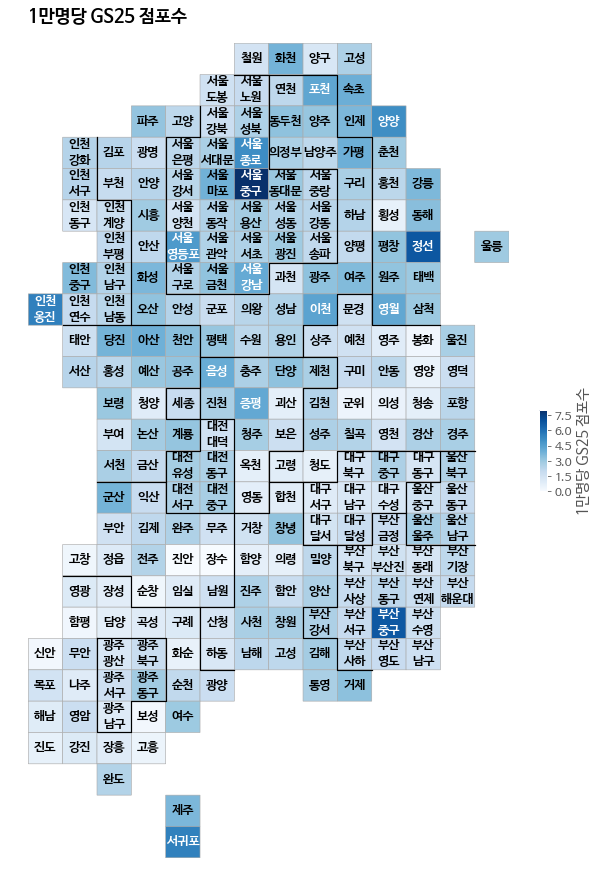

In [53]:
df['1만명당 GS25 점포수'] = df['GS25'] / df['인구수'] * 10000
draw_blockmap('1만명당 GS25 점포수', df, 'd1_y', 'd2_y', 'Blues', np.arange(0, 10.1, 1.5), '1만명당 GS25 점포수')

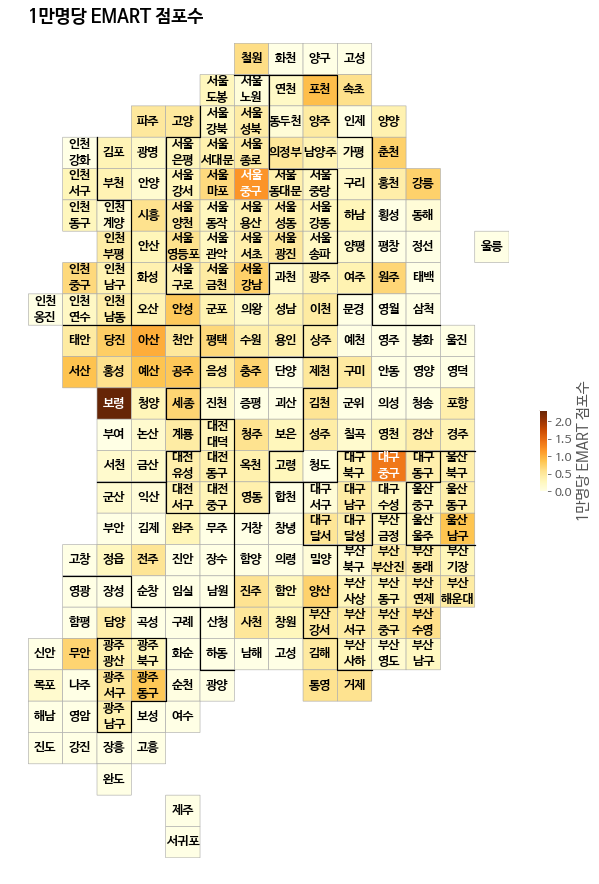

In [54]:
df['1만명당 EMART 점포수'] = df['EMART'] / df['인구수'] * 10000
draw_blockmap('1만명당 EMART 점포수', df, 'd1_y', 'd2_y', 'YlOrBr', np.arange(0, 2.1, 0.5), '1만명당 EMART 점포수')

인구밀도 해보려니 뭔가이상...ㅇㅁㅇ,,,,, 

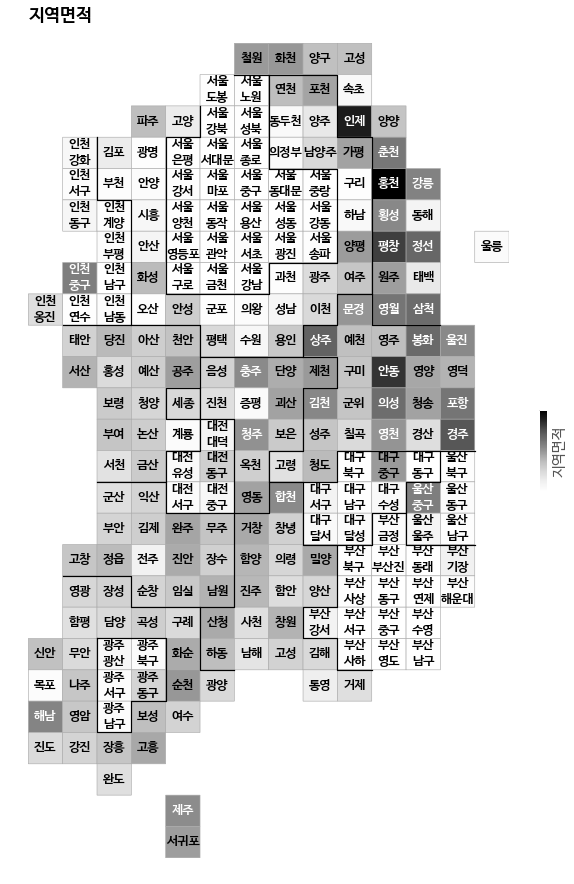

In [55]:
draw_blockmap('지역면적', df, 'd1_y', 'd2_y', 'Greys', np.arange(0), '지역면적')